In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from ast import literal_eval
import time
from datetime import timedelta
import pickle

from scipy.sparse import hstack, vstack, csr_matrix, load_npz, save_npz

pd.set_option('display.width', 1400)

#### Functions

In [7]:
# TF-IDF Content Based Recommendations
def load_recommendations_for_all_users(save_dir='recommendations', limit=None):
    if not os.path.exists(save_dir):
        print('savedir doesnt exist:', save_dir)
        return None
    user_ids, recipes, sims = [], [], []
    n_items = len(os.listdir(save_dir))
    for i, item in enumerate(os.listdir(save_dir)):
        print('\rLoading {:_}/{:_}'.format(i+1, n_items), end='')
        user_id = item.split('.')[0]
        itempath = os.path.join(save_dir, item)
        try:
            with open(itempath, 'rb') as f:
                recommended_recipes, recommended_sims = pickle.load(f)
            user_ids.append(user_id)
            recipes.append(recommended_recipes)
            sims.append(recommended_sims)
        except:
            print('\nError: Unable to read "{}"'.format(itempath))
        if limit and i >= limit: break
    print('\nDone.')
    df_recommend = pd.DataFrame({'user_id': user_ids, 'recommended_recipes': recipes, 'recommended_sims': sims})
    df_recommend = df_recommend.set_index('user_id')
    return df_recommend

In [4]:
def load_user_recommendations_collabFilter(save_name='dataset/recommendations_collabFilter.pkl'):
    with open(save_name, 'rb') as f:
        recommendations = pickle.load(f)
    return recommendations

#### Load Data

In [2]:
# Create/Load Training and Test data
converters = { k: literal_eval for k in ['rated_recipes', 'ingredients', 'rating_list'] }
train_fn = 'dataset/User_Data_Train.csv'
test_fn = 'dataset/User_Data_Test.csv'
if os.path.exists(train_fn):
    print('Loading train and test userdata ...')
    df_train = pd.read_csv(train_fn, converters=converters, index_col='user_id')
    df_test =  pd.read_csv(test_fn, converters=converters, index_col='user_id')
else:
    print('No train and test data ...')
print('Done.')

Loading train and test userdata ...
Done.


In [ ]:
# 
converters = { k: literal_eval for k in ['tags', 'ingredients', 'steps', 'nutrition'] } # for evaluating strings as arrays (eg. tags)
df_recipes = pd.read_csv('dataset/RAW_recipes.csv', converters=converters, index_col='id')

id_to_index_RECIPES = { id_: i for i, id_ in enumerate(df_recipes.index) }
index_to_id_RECIPES = { i: id_ for i, id_ in enumerate(df_recipes.index) }

In [ ]:
# LOAD: TF-IDF Content-Based recommendations
try:
    df_recommend_TFIDF = load_recommendations_for_all_users('dataset/recommendations_contentBased_tfidf')
    df_recommend_TFIDF['recommend_count'] = df_recommend_TFIDF['recommended_recipes'].apply(lambda x: len(x))
    df_recommend_TFIDF
except KeyboardInterrupt:
    print('\nKeyboard interrupt detected ...')

Loading 31_837/31_837
Done.


In [107]:
# LOAD: DistilBERT Content-Based recommendations
converters = { k: literal_eval for k in ['recommended_recipes', 'recommended_sims'] }
df_recommend_BERT = pd.read_csv('dataset/recommendations_BERT/recommend_BERT.csv', index_col='user_id').dropna()
df_recommend_BERT['recommend_count'] = df_recommend_BERT['recommended_recipes'].apply(lambda x: len(x))
df_recommend_BERT['recommended_recipes'] = df_recommend_BERT['recommended_recipes'].apply(lambda str: literal_eval(str))
# df_recommend_BERT['recommended_recipes'] = df_recommend_BERT['recommended_recipes_idx'].apply(lambda lst: [index_to_id_RECIPES.get(x, x) for x in lst])
df_recommend_BERT.head()

,recommended_recipes,recommended_sims,recommend_count
user_id,,,
1533,"[400688, 20028, 196498, 152760, 185480, 263339...","[0.6412452, 0.644295, 0.6796208, 0.7549678, 0....",7759
1535,"[400688, 20028, 196498, 152760, 185480, 263339...","[0.6494462, 0.6584604, 0.69681334, 0.7743182, ...",7767
1581,"[400688, 20028, 196498, 39530, 152760, 185480,...","[0.65069044, 0.65314263, 0.7163571, 0.7672188,...",7751
1634,"[400688, 20028, 196498, 152760, 185480, 263339...","[0.63880986, 0.65031195, 0.69209564, 0.7655211...",7757
1676,"[400688, 20028, 196498, 152760, 185480, 263339...","[0.64233106, 0.6427235, 0.671031, 0.74525243, ...",7754


In [60]:
# LOAD: Collaborative Filtering-Based recommendations
recommend_CF = load_user_recommendations_collabFilter()
d = {}
d['user_id'] = recommend_CF.keys()
d['recommended_recipes'] = recommend_CF.values()
df_recommend_CF = pd.DataFrame(d)
df_recommend_CF.set_index('user_id', inplace=True)
df_recommend_CF['recommend_count'] = df_recommend_CF['recommended_recipes'].apply(lambda x: len(x))
df_recommend_CF.head()

,recommended_recipes,recommend_count
user_id,,
1533,"[46169, 68142, 51209, 94535, 106969, 28240, 17...",1000
1535,"[60559, 49530, 31078, 81853, 53914, 42564, 584...",1000
1581,[],0
1634,"[14927, 19871, 136367, 61180, 41992, 72308, 23...",1000
1676,"[119258, 14384, 21343, 150925, 23198, 18128, 1...",1000


#### Evaluation

In [226]:
# Recommender Evaluation Metrics
def get_relevant_items(recommended, liked):
    return [ x for x in recommended if x in liked ]

def get_precision(recommended, liked):
    if len(recommended) == 0:
        return np.nan
    true_positives = get_relevant_items(recommended, liked)
    return len(true_positives) / len(recommended)

def get_recall(recommended, liked):
    if len(liked) == 0:
        return np.nan
    true_positives = get_relevant_items(recommended, liked)
    return len(true_positives) / len(liked)

def get_f_score(recommended, liked, beta=1):
    precision = get_precision(recommended, liked)
    recall = get_recall(recommended, liked)
    if precision == 0 and recall == 0:
        return np.nan
    return (1 + beta**2) * (precision * recall) / ((precision*beta**2) + recall)

def get_mean_average_precision(recommended, liked):
    precisions = []
    true_positives = [ x for x in recommended if x in liked ]
    for i in range(1, len(recommended)+1):
        Slice = recommended[:i]
        precisions.append(get_precision(Slice, liked))
    precisions = np.array(precisions, dtype=np.float64)
    sum = np.sum(precisions, dtype=np.float64)
    if sum == 0:
        return np.nan
    return len(true_positives) * sum

def get_rank(recommended, liked):
    if liked == [] or recommended == []:
        return np.nan
    true_positives = get_relevant_items(recommended, liked)
    if true_positives == []:
        return np.nan
    return recommended.index(true_positives[0])

def get_mean_reciprocal_rank(ranks):
    rr = 1 / (np.array(ranks)+1)
    return np.mean(rr)

In [114]:
# 
print('tdifd recommendations:', len(df_recommend_TFIDF))
print('bert recommendations:', len(df_recommend_BERT))
print('cf recommendations:', len(df_recommend_CF))
print('of which non zero:', len([x for x in df_recommend_CF['recommend_count'].to_numpy() if x != 0]))

tdifd recommendations: 31837
bert recommendations: 8001
cf recommendations: 1316
of which non zero: 328


In [22]:
# 
funcs = {
    'f_score': get_f_score,
    'MAP': get_mean_average_precision,
    'rank': get_rank
}

In [76]:
# 
df = df_recommend_CF
results_CF = []
print(' {:>12} : {:>7} :   {:<10} {:<10} {:<10}'.format('user_id', 'index', *funcs.keys()))
for i, user_id in enumerate(df.index):
    recommended = df.loc[user_id]['recommended_recipes']
    recipes_test = df_test.loc[int(user_id)]['rated_recipes']
    ratings_test = df_test.loc[int(user_id)]['rating_list']
    liked = [ recipe for recipe, rating in zip(recipes_test, ratings_test) if rating >= 3 ]
    result = { name: func(recommended, liked) for name, func in funcs.items() }
    if [ v for v in result.values() if not np.isnan(v) ] != []:
        result['index'] = i
        result['user_id'] = user_id
        results_CF.append(result)
        print(' {:>12} : {:>7} :   {:<10.4f} {:<10.4f} {:<10.4f} '.format(user_id, i, *result.values()))
print('Amount of non-NaN evaluations:', len(results_CF))

      user_id :   index :   f_score    MAP        rank      
         1533 :       0 :   0.0039     5.7305     153.0000   
         1535 :       1 :   0.0104     52.6659    5.0000     
         1792 :       7 :   0.0020     0.0866     917.0000   
         1891 :       8 :   0.0020     0.7460     474.0000   
         1962 :      10 :   0.0020     1.2860     276.0000   
         2310 :      26 :   0.0037     2.5806     512.0000   
         2586 :      37 :   0.0060     20.7088    12.0000    
         3205 :      65 :   0.0020     1.0404     353.0000   
         3288 :      72 :   0.0077     17.8356    236.0000   
         4291 :     170 :   0.0019     0.0111     989.0000   
         4470 :     193 :   0.0013     0.9485     387.0000   
         4740 :     216 :   0.0019     0.1554     856.0000   
         5060 :     234 :   0.0074     44.1086    76.0000    
         6258 :     366 :   0.0035     4.4272     270.0000   
         6357 :     377 :   0.0031     5.8218     189.0000   
         

In [78]:
# evaluation results for TFIDF
df = df_recommend_TFIDF
results_TFIDF = []
print(' {:>12} : {:>7} :   {:<10} {:<10} {:<10}'.format('user_id', 'index', *funcs.keys()))
for i, user_id in enumerate(df.index):
    recommended = df.loc[user_id]['recommended_recipes']
    recipes_test = df_test.loc[int(user_id)]['rated_recipes']
    ratings_test = df_test.loc[int(user_id)]['rating_list']
    liked = [ recipe for recipe, rating in zip(recipes_test, ratings_test) if rating >= 3 ]
    result = { name: func(recommended, liked) for name, func in funcs.items() }
    if [ v for v in result.values() if not np.isnan(v) ] != []:
        result['index'] = i
        result['user_id'] = user_id
        results_TFIDF.append(result)
        print(' {:>12} : {:>7} :   {:<10.4f} {:<10.4f} {:<10.4f} '.format(user_id, i, *result.values()))
print('Amount of non-NaN evaluations:', len(results_TFIDF))

      user_id :   index :   f_score    MAP        rank      
       100149 :      15 :   0.0194     0.4750     62.0000    
        10033 :      44 :   0.0131     2.2584     10.0000    
       100920 :     109 :   0.0545     7.4458     26.0000    
       100980 :     119 :   0.0190     0.2860     75.0000    
       101100 :     131 :   0.0198     0.8147     44.0000    
       101253 :     155 :   0.0192     0.5411     58.0000    
       101275 :     161 :   0.0141     0.2994     74.0000    
       101320 :     170 :   0.0198     0.0100     99.0000    
       101661 :     205 :   0.0198     2.4695     8.0000     
       101732 :     213 :   0.0093     0.4750     62.0000    
       101919 :     239 :   0.0171     1.2602     28.0000    
       102064 :     257 :   0.0194     0.0938     91.0000    
       102299 :     286 :   0.0182     0.4281     65.0000    
       102526 :     320 :   0.0165     0.4911     61.0000    
       102602 :     331 :   0.0172     0.4435     64.0000    
       10

In [115]:
# evaluation results for BERT
df = df_recommend_BERT
results_BERT = []
print(' {:>12} : {:>7} :   {:<10} {:<10} {:<10}'.format('user_id', 'index', *funcs.keys()))
for i, user_id in enumerate(df.index):
    recommended = df.loc[user_id]['recommended_recipes']
    recommended = recommended[:1000]
    recipes_test = df_test.loc[int(user_id)]['rated_recipes']
    ratings_test = df_test.loc[int(user_id)]['rating_list']
    liked = [ recipe for recipe, rating in zip(recipes_test, ratings_test) if rating >= 3 ]
    result = { name: func(recommended, liked) for name, func in funcs.items() }
    if [ v for v in result.values() if not np.isnan(v) ] != []:
        result['index'] = i
        result['user_id'] = user_id
        results_BERT.append(result)
        print(' {:>12} : {:>7} :   {:<10.4f} {:<10.4f} {:<10.4f} '.format(user_id, i, *result.values()))
print('Amount of non-NaN evaluations:', len(results_BERT))

      user_id :   index :   f_score    MAP        rank      
         1535 :       1 :   0.0017     0.0597     942.0000   
         4291 :     170 :   0.0019     0.0823     921.0000   
         4470 :     193 :   0.0013     1.1076     330.0000   
         4740 :     216 :   0.0019     2.8565     57.0000    
         5060 :     234 :   0.0015     0.9961     369.0000   
         6258 :     366 :   0.0017     0.5444     580.0000   
         6357 :     377 :   0.0016     0.5992     549.0000   
         7108 :     439 :   0.0019     0.2168     805.0000   
         7802 :     484 :   0.0020     0.0263     974.0000   
         8629 :     555 :   0.0035     3.4251     185.0000   
         8688 :     562 :   0.0016     0.5426     581.0000   
         9579 :     630 :   0.0039     1.0510     639.0000   
         9717 :     644 :   0.0019     0.9180     399.0000   
         9869 :     653 :   0.0049     0.8777     822.0000   
        11176 :     767 :   0.0019     0.5617     570.0000   
        1

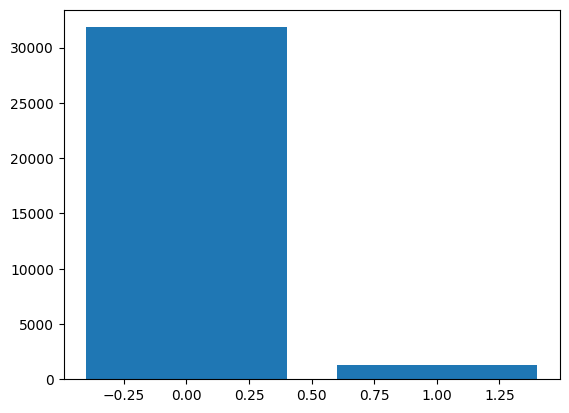

In [138]:
# 

plt.bar([0, 1], [len(df_recommend_TFIDF), len(results_TFIDF)])
plt.show()

In [148]:
dfs = {
    'TFIDF': df_recommend_TFIDF,
    'CF': df_recommend_CF,
    'BERT': df_recommend_BERT
}
results = {
    'TFIDF': results_TFIDF,
    'CF': results_CF,
    'BERT': results_BERT
}

0
0
988


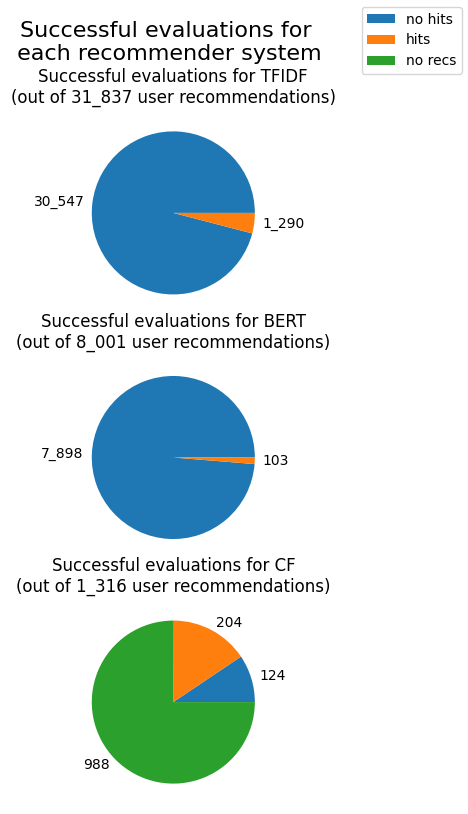

In [253]:

fig, ax = plt.subplots(3, 1, figsize=(6,9))
labels_base = ['no hits', 'hits', 'no recs']

names = ['TF-IDF Content Based', 'DistilBERT', 'Collaborative Filterin']

for i, name in enumerate('TFIDF BERT CF'.split()):
    df = dfs[name]
    result = results[name]
    total_n = len(df)
    results_n = len(result)
    without_recs_n = len([x for x in df['recommend_count'].to_numpy() if x == 0])
    data = [total_n-results_n-without_recs_n, results_n, without_recs_n]
    ax[i].set_title(f'Successful evaluations for {name}\n(out of {total_n:_} user recommendations)')
    labels = [ f'{d:_}' for d in data ]
    print(without_recs_n)
    if without_recs_n == 0:
        labels[-1] = ''
    ax[i].pie(data, labels=labels)
fig.legend(labels_base)#, loc="top left")
fig.suptitle('Successful evaluations for\n each recommender system', fontsize=16)
plt.show()

In [210]:
# Extract results into separate columns
evaluation_results = {}
for name, result in results.items():
    evals = {}
    for metric in ['rank', 'f_score', 'MAP']:
        evals[metric] = [ res[metric] for res in result ]
    evaluation_results[name] = evals

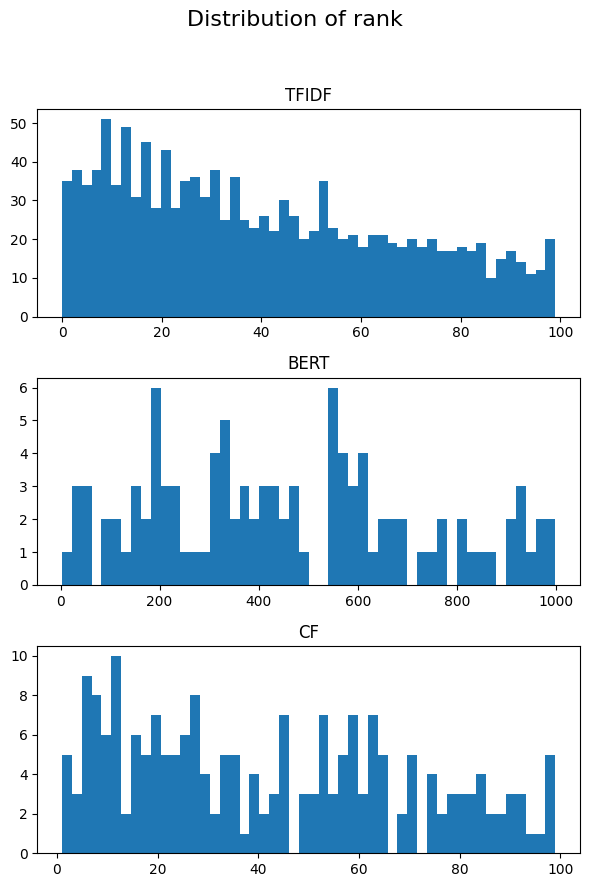

In [211]:
# RANK
metric = 'rank'
fig, ax = plt.subplots(nrows=3, figsize=(6,9))
for i, name in enumerate('TFIDF BERT CF'.split()):
    # data = [ res[metric] for res in results[name] ]
    data = evaluation_results[name][metric]
    ax[i].hist(data, bins=50)
    ax[i].set_title(name)
fig.suptitle(f'Distribution of {metric}', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

C:\Users\stirl\AppData\Local\Temp\ipykernel_18560\2186184988.py:10: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax[i].set_ylim(0, 1000)


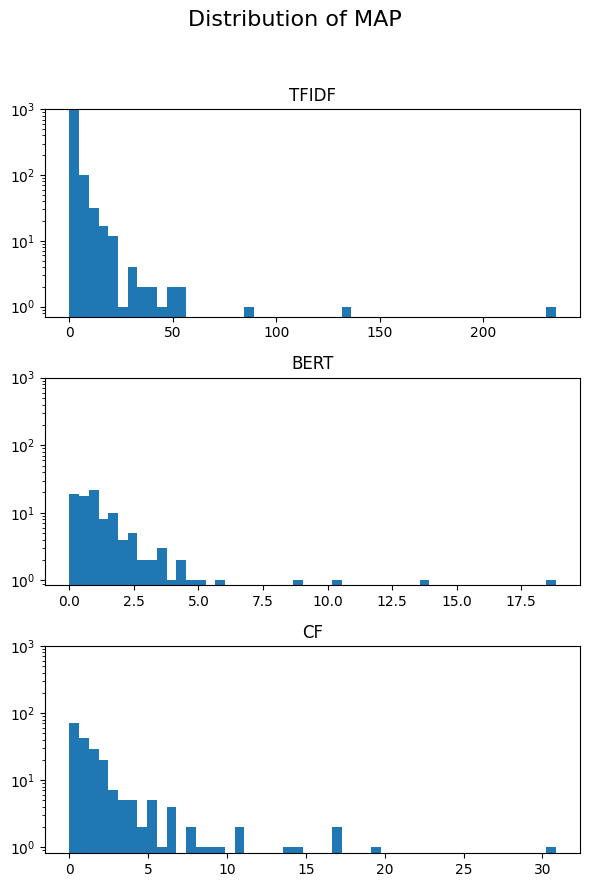

In [ ]:
# MAP
metric = 'MAP'
fig, ax = plt.subplots(nrows=3, figsize=(6,9))
for i, name in enumerate('TFIDF BERT CF'.split()):
    data = evaluation_results[name][metric]
    ax[i].hist(data, bins=50)
    ax[i].set_title(name)
    ax[i].set_yscale('log')
    ax[i].set_ylim(0, 1000)
fig.suptitle(f'Distribution of {metric}', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

C:\Users\stirl\AppData\Local\Temp\ipykernel_18560\1926652831.py:9: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax[i].set_ylim(0, 600)


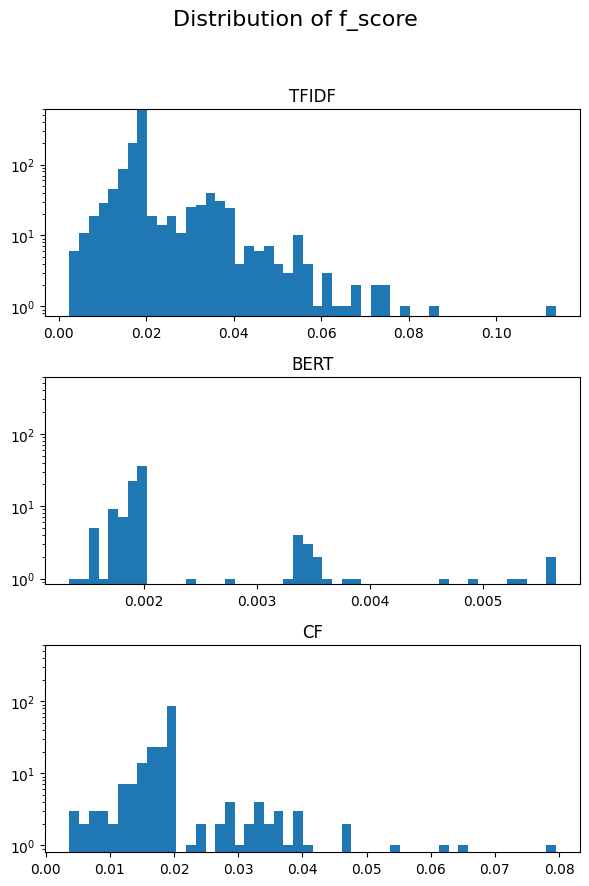

In [ ]:
# F Score
metric = 'f_score'
fig, ax = plt.subplots(nrows=3, figsize=(6,9))
for i, name in enumerate('TFIDF BERT CF'.split()):
    data = evaluation_results[name][metric]
    ax[i].hist(data, bins=50)
    ax[i].set_title(name)
    ax[i].set_yscale('log')
    ax[i].set_ylim(0, 600)
fig.suptitle(f'Distribution of {metric}', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [ ]:
# Calculate overall metrics
overall_metrics = {}
for metric in ['MAP', 'f_score']:
    metrics = {}
    for name, result in evaluation_results.items():
        ave = np.mean(result[metric])
        # print(name, ave)
        metrics[name] = ave
    overall_metrics[metric] = metrics

MRRS = {}
for name, result in evaluation_results.items():
    MRRS[name] = get_mean_reciprocal_rank(result['rank'])
overall_metrics['MRR'] = MRRS
overall_metrics

{'MAP': {'TFIDF': 3.0866951201474575,
  'CF': 2.187443445331656,
  'BERT': 1.7821129725708251},
 'f_score': {'TFIDF': 0.021436049010041067,
  'CF': 0.02029139936003724,
  'BERT': 0.002290221651052013},
 'MRR': {'TFIDF': 0.06664277490103511,
  'CF': 0.05267347890772391,
  'BERT': 0.006579418884058134}}

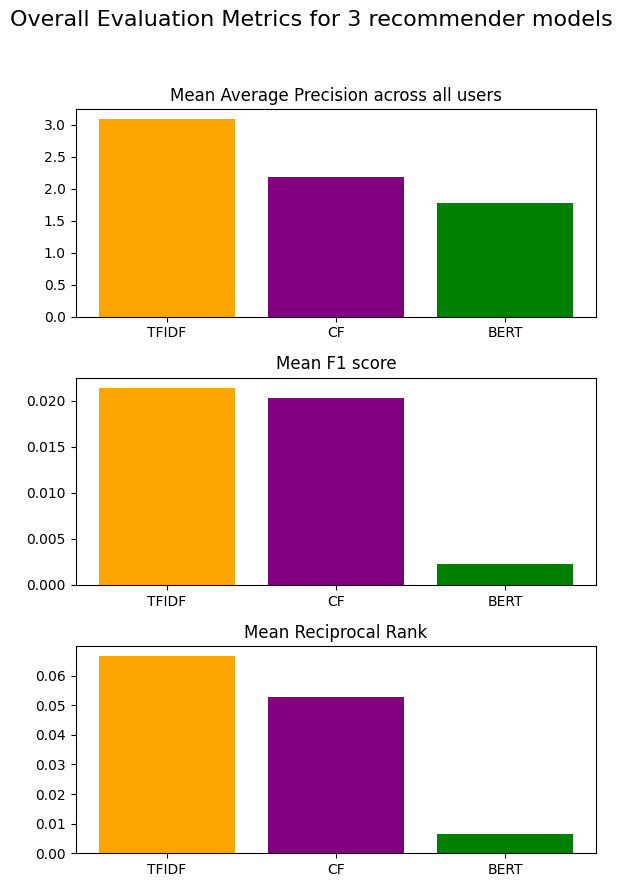

In [ ]:
# 
fig, ax = plt.subplots(3, 1, figsize=(6,9))
subtitles = ['Mean Average Precision across', 'Mean F1 score', 'Mean Reciprocal Rank']
for i, (title, metrics) in enumerate(overall_metrics.items()):
    ax[i].bar(list(metrics.keys()), list(metrics.values()), color=['orange', 'purple', 'green'])
    ax[i].set_title(subtitles[i])
plt.suptitle('Overall Evaluation Metrics for 3 recommender models', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [ ]:
# Adjust evaluation results
import copy
evaluation_results_adj = copy.deepcopy(evaluation_results)
for name, df in dfs.items():
    print(len(df))
    f_score = evaluation_results_adj[name]['f_score']
    map = evaluation_results_adj[name]['MAP']
    rank = evaluation_results_adj[name]['rank']
    for i in range(len(df)-len(f_score)):
        f_score.append(0)
        map.append(0)
        rank.append(1000)
    evaluation_results_adj[name]['f_score'] = f_score
    evaluation_results_adj[name]['MAP'] = map
    evaluation_results_adj[name]['rank'] = rank

31837
1316
8001


In [270]:
# Calculate overall metrics (adjusted)
overall_metrics_adj = {}
for metric in ['MAP', 'f_score']:
    metrics = {}
    for name, result in evaluation_results_adj.items():
        ave = np.mean(result[metric])
        # print(name, ave)
        metrics[name] = ave
    overall_metrics_adj[metric] = metrics

MRRS = {}
for name, result in evaluation_results_adj.items():
    MRRS[name] = get_mean_reciprocal_rank(result['rank'])
overall_metrics_adj['MRR'] = MRRS
overall_metrics_adj

{'MAP': {'TFIDF': 0.12506946964193297,
  'CF': 0.3390869778477643,
  'BERT': 0.022941836792250345},
 'f_score': {'TFIDF': 0.0008685649785769067,
  'CF': 0.003145475280735258,
  'BERT': 2.948291839249561e-05},
 'MRR': {'TFIDF': 0.00365881405719191,
  'CF': 0.009009330401265038,
  'BERT': 0.0010708398994085592}}

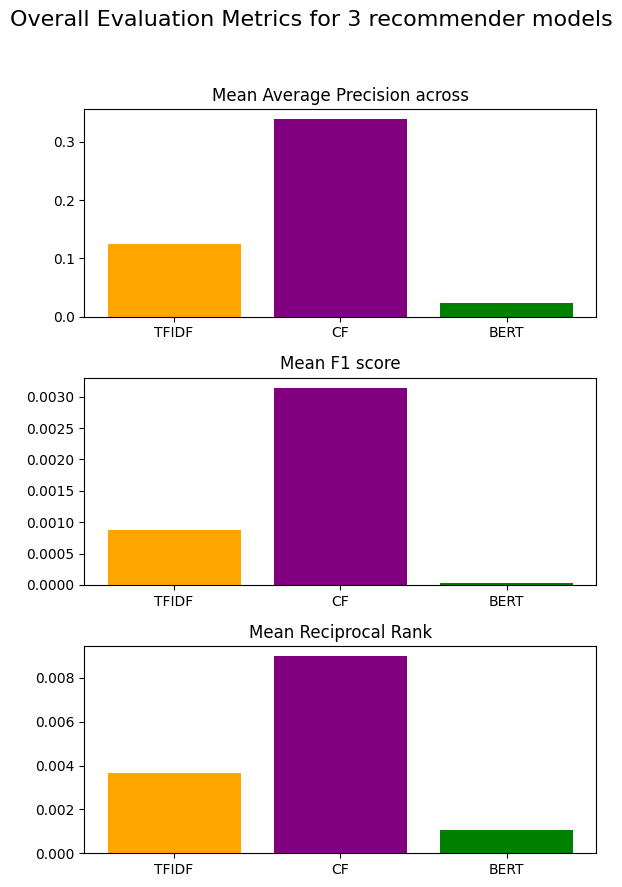

In [271]:
fig, ax = plt.subplots(3, 1, figsize=(6,9))
subtitles = ['Mean Average Precision across', 'Mean F1 score', 'Mean Reciprocal Rank']
for i, (title, metrics) in enumerate(overall_metrics_adj.items()):
    ax[i].bar(list(metrics.keys()), list(metrics.values()), color=['orange', 'purple', 'green'])
    ax[i].set_title(subtitles[i])
plt.suptitle('Overall Evaluation Metrics for 3 recommender models', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()